In [57]:
pip install torch==1.13.0+cu121 torchvision==0.14.0+cu118 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.13.0+cu118 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.0+cu118, 2.0.1, 2.0.1+cu118, 2.1.0, 2.1.0+cu118, 2.1.1, 2.1.1+cu118, 2.1.2, 2.1.2+cu118, 2.2.0, 2.2.0+cu118, 2.2.1, 2.2.1+cu118, 2.2.2, 2.2.2+cu118, 2.3.0, 2.3.0+cu118, 2.3.1, 2.3.1+cu118)
ERROR: No matching distribution found for torch==1.13.0+cu118

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import numpy as np
import os
from PIL import Image
import cv2
import random
import sys

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# cuda 사용 가능 여부 확인
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Current Device : {}".format(device))


Current Device : cuda


In [4]:
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3070'

In [5]:
torch.cuda.current_device()

0

In [6]:
# 시드 고정
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
set_random_seed(7777)

In [7]:
# 파일 경로명 지정
file_dir = "./colab/colab/"

In [58]:
# 데이터 전처리 및 DataSet 만들기(사전에 디렉토리 나누기 필수)
train_dir = os.path.join(file_dir + "train/")
test_dir = os.path.join(file_dir + "test/")

train_trans = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

test_trans = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

trainset = torchvision.datasets.ImageFolder(root = train_dir, transform = train_trans)
testset = torchvision.datasets.ImageFolder(root = test_dir, transform = train_trans)

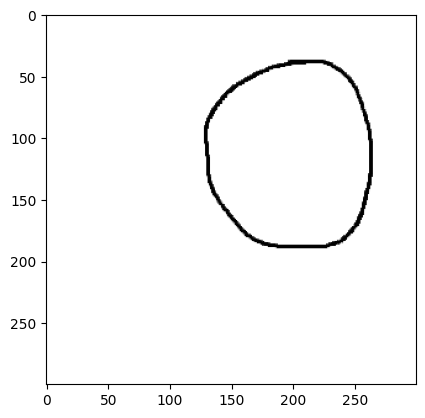

In [59]:
# 데이터셋 테스트, 가장 첫번째 이미지 불러오기(train\o\o_1.png)
plt.imshow(transforms.ToPILImage()(trainset[0][0]), cmap='gray')

In [60]:
# HyperParameter
n_batch = 16

# DataLoader 만들기
trainloader = DataLoader(trainset, batch_size = n_batch, shuffle = True, num_workers = 4)
testloader = DataLoader(testset, batch_size = n_batch, shuffle = True, num_workers = 4) # 사전에 랜덤으로 섞어놓은 상태라 테스트셋 셔플이 의미가 있나 싶지만.. 그래도

In [61]:
# train 데이터셋을 batch 단위로 순회하는 iterator
it = iter(trainloader)

클래스: ['o', 'x']
데이터셋 크기: 224


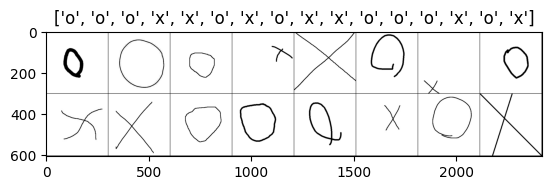

torch.Size([1, 300, 300])


In [62]:
# 현재 batch 꺼내보기(연속으로 실행 시 다음 batch로 이동)
img, label = next(it) # 다음 순서로 넘어감
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    #mean = np.array([0.43303847, 0.4034577, 0.39415097])
    #std = np.array([0.18344551, 0.17549995, 0.1647388])
    #input = std * input + mean
    input = np.clip(input, 0, 1)

    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


class_names = trainset.classes
print('클래스:', class_names)

out = torchvision.utils.make_grid(img)
print('데이터셋 크기:', len(trainset))

imshow(out, title=[class_names[x] for x in label])
print(img[0].shape)

In [23]:
# nn.Linear 입력차원 계산
ks = (3, 3)

imgs, labels = next(iter(trainloader))
m = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),
    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = ks, padding = "same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2)
    )
out = m(imgs)
print(imgs.shape)
out.shape

torch.Size([1, 1, 300, 300])


torch.Size([1, 128, 18, 18])

In [24]:
# CNN 모델 구성
ks = (3, 3)

class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = ks, padding = "same")
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = ks, padding = "same")
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = ks, padding = "same")       
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = ks, padding = "same")       
        
        self.pooling = nn.MaxPool2d(kernel_size = 2)
        
        self.fc1 = nn.Linear(128*18*18, 1024)
        self.fc2 = nn.Linear(1024, 2)

        self.relu = nn.ReLU()

        #self.dropout = nn.Dropout(0.25)
        self.dropout1 = nn.Dropout(0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pooling(x)
        #x = self.dropout(x)
        
        
        x = torch.flatten(x, start_dim = 1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        #x = self.relu(x)

        #CrossEntropyLoss에 기본으로 softmax 제공
        #x = F.log_softmax(x, dim = 1)
        return x

In [63]:
# 모델 구성 미리보기
from torchinfo import summary

m = CNN1()
summary(m, (32, 1, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [32, 2]                   --
├─Conv2d: 1-1                            [32, 16, 300, 300]        160
├─ReLU: 1-2                              [32, 16, 300, 300]        --
├─MaxPool2d: 1-3                         [32, 16, 150, 150]        --
├─Conv2d: 1-4                            [32, 32, 150, 150]        4,640
├─ReLU: 1-5                              [32, 32, 150, 150]        --
├─MaxPool2d: 1-6                         [32, 32, 75, 75]          --
├─Conv2d: 1-7                            [32, 64, 75, 75]          18,496
├─ReLU: 1-8                              [32, 64, 75, 75]          --
├─MaxPool2d: 1-9                         [32, 64, 37, 37]          --
├─Conv2d: 1-10                           [32, 128, 37, 37]         73,856
├─ReLU: 1-11                             [32, 128, 37, 37]         --
├─MaxPool2d: 1-12                        [32, 128, 18, 18]         --
├─L

In [16]:
# 훈련 함수

def train_loop(dataloader, model, loss_fn, optimizer, device):

    model.train() # 학습 모드
    for batch, (X, y) in enumerate(dataloader):
  
        X, y = X.to(device), y.to(device)
    
        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return loss.item()



In [17]:
# 테스트 함수
def test_loop(dataloader, model, loss_fn, device):
    model.eval() # 평가 모드
    num_corr = 0
    test_loss, test_acc = 0.0,0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)

            preds = pred.data.max(1)[1]
            corr = preds.eq(y.to(device).data).sum().item()
            num_corr += corr
            
            test_loss += loss_fn(pred,y)
    
    test_loss /= len(dataloader) #step 수로 나누기.
    #test_acc /= len(dataloader.dataset) #총 데이터수로 나누기.
    test_acc = num_corr / len(dataloader.dataset)
    

    test_loss = round(float(test_loss), 4)
    test_acc = round(float(test_acc), 4)
      
    #print(f"Test loss: {test_loss}, Test accuracy: {test_acc * 100}%")
      
    return test_acc, test_loss

In [66]:
# 모델 train + test, 생성된 모델의 평균 loss & accuracy 출력
epochs = 400
learning_rate = 0.001
min_val_loss = 2.0

model = CNN1().to(device)
lf = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss = []
acc = []

for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    tr_loss = train_loop(trainloader, model, lf, opt, device)
    ts_acc, ts_loss = test_loop(testloader, model, lf, device)

    #tr_loss = round(tr_loss, 4)
    ts_acc = round(ts_acc, 4)
    ts_loss = round(ts_loss, 4)

    acc.append(ts_acc)
    loss.append(ts_loss)
    
    #if(t % 5 == 0 or t == 49):
    print("epoch({} / {})$ test_loss == {}, test_acc == {}".format(t + 1, epochs, ts_loss, ts_acc))
    
    # loss 값이 최저를 갱신할 때마다 모델을 저장
    if np.round(min_val_loss, 5) > np.round(ts_loss, 5):
        min_val_loss = ts_loss
        n_patience = 0
        torch.save(model.state_dict(), f'./best_model/0718/best_w_{t + 1}.pth')
        print('loss 최저치 갱신, 현재 모델 저장, best_w_{}.pth'.format(t + 1))
    else:
        n_patience += 1
    # 5번 연속으로 loss가 증가할 시 overfitting으로 판단, 종료
    #if n_patience > 5:
            #print(f"계속되는 loss 증가로 인한 종료. 마지막 epoch : {t + 1}")
            #break


    

print("종료.")

epoch(1 / 400)$ test_loss == 0.4562, test_acc == 0.7857
loss 최저치 갱신, 현재 모델 저장, best_w_1.pth
epoch(2 / 400)$ test_loss == 0.4422, test_acc == 0.7679
loss 최저치 갱신, 현재 모델 저장, best_w_2.pth
epoch(3 / 400)$ test_loss == 0.3109, test_acc == 0.875
loss 최저치 갱신, 현재 모델 저장, best_w_3.pth
epoch(4 / 400)$ test_loss == 0.3789, test_acc == 0.8036
epoch(5 / 400)$ test_loss == 0.2171, test_acc == 0.8571
loss 최저치 갱신, 현재 모델 저장, best_w_5.pth
epoch(6 / 400)$ test_loss == 0.2768, test_acc == 0.9107
epoch(7 / 400)$ test_loss == 0.399, test_acc == 0.9107
epoch(8 / 400)$ test_loss == 0.2567, test_acc == 0.9107
epoch(9 / 400)$ test_loss == 0.7873, test_acc == 0.8929
epoch(10 / 400)$ test_loss == 0.156, test_acc == 0.9643
loss 최저치 갱신, 현재 모델 저장, best_w_10.pth
epoch(11 / 400)$ test_loss == 0.2251, test_acc == 0.9286
epoch(12 / 400)$ test_loss == 0.2219, test_acc == 0.9286
epoch(13 / 400)$ test_loss == 0.373, test_acc == 0.9286
epoch(14 / 400)$ test_loss == 0.3004, test_acc == 0.9286
epoch(15 / 400)$ test_loss == 0.28

In [65]:
#gpu 캐시 비우기
torch.cuda.empty_cache()

### K-Fold Cross Validation

시행 해봤으나 위에 단일모델에서 그냥 loss 최저 찍을때마다 저장하는 것이 더 효율적이라 폐기

In [26]:
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [37]:
kfold = KFold(n_splits=5, shuffle=True)

In [ ]:
#lr_s = ReduceLROnPlateau(opt, mode='min', patience=4,factor=0.2)

trn_loss,trn_acc = [],[]
val_loss,val_acc = [],[]
train_ds = trainset
kmodel = CNN1().to(device)

for i, (trn_idx,val_idx) in enumerate(kfold.split(train_ds)):
    print(f"Fold {i}")
    min_val_loss = 2
    n_patience = 0

    trn_ds = Subset(train_ds, trn_idx)
    val_ds = Subset(train_ds, val_idx)
    trn_dl = DataLoader(trn_ds, batch_size=n_batch, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=n_batch, shuffle=False)

    for epoch in range(100):
        trn_l  = train_loop(trn_dl, kmodel, lf, opt, device)
        val_a, val_l= test_loop(val_dl, kmodel, lf, device)

        if np.round(min_val_loss, 5) > np.round(val_l, 5) :
            min_val_loss = val_l
            n_patience = 0
            print(f'epoch {epoch}: Save the best params with val_loss:{val_l:.4f}, val_acc:{val_a:.4f}')
            torch.save(kmodel.state_dict(), f'./best_w_{i}.pth')
        else:
            n_patience += 1

        #lr_s.step(val_l)
        if n_patience > 7:
            print(f"Early Stopping at epoch{epoch}")
            break

    trn_loss.append(trn_l)
    #trn_acc.append(trn_a)
    val_loss.append(val_l)
    val_acc.append(val_a)
    print(f"\t Train loss {np.mean(trn_loss):.4f}")
    print(f"\t Valid loss {np.mean(val_loss):.4f} | acc {np.mean(val_acc):.4f}")

In [40]:
md.eval()
ts_acc, ts_loss = test_loop(testloader, md, lf, device)
print("ts_acc : {} / ts_loss : {}".format(ts_acc, ts_loss))


ts_acc : 0.8393 / ts_loss : 0.2872


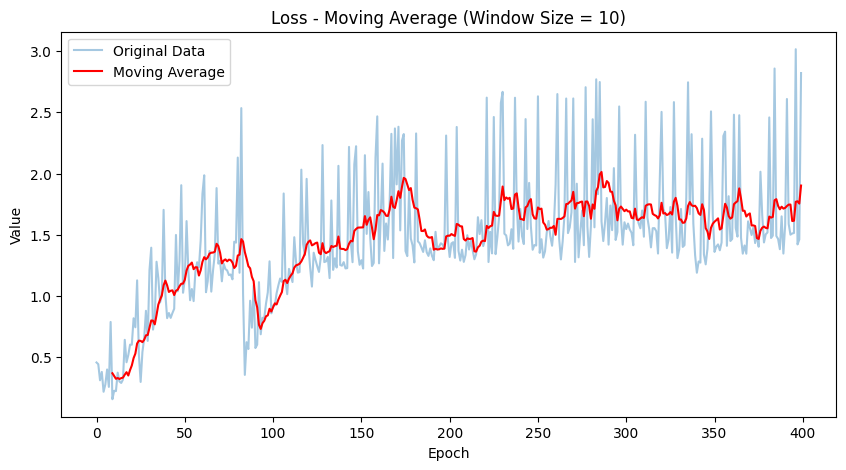

In [69]:
def moving_average(data, window_size):
    averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        averages.append(window_average)
    return averages

def plot_moving_average(data, window_size):
    averages = moving_average(data, window_size)
    plt.figure(figsize=(10, 5))
    plt.plot(data, label='Original Data', alpha = 0.4)
    plt.plot(range(window_size - 1, len(data)), averages, label='Moving Average', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Loss - Moving Average (Window Size = {window_size})')
    plt.legend()
    plt.show()

plot_moving_average(loss, 10)

In [83]:
import sys
import numpy as np
import cv2


md = model
PATH = "./best_model/0718/best_w_10.pth"
#md = CNN1().to(device)
#md.load_state_dict(torch.load(PATH))
md.eval()

oldx = oldy = -1  # 좌표 기본값 설정
canvas_size = (300, 330)  # 전체 캔버스 크기
drawing_area_size = (300, 300)  # 그리기 영역 크기
button_size = (50, 30)  # 버튼 크기
save_button_position = (canvas_size[0] - button_size[0], canvas_size[1] - button_size[1], button_size[0], button_size[1])  # 버튼의 위치와 크기 (x, y, width, height)

def OpenCV2PIL(opencv_image):
    color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(color_coverted)
    return pil_image

def on_mouse(event, x, y, flags, param):
    global oldx, oldy  # 밖에 있는 oldx, oldy 불러옴

    if event == cv2.EVENT_LBUTTONDOWN:  # 왼쪽이 눌러지면 실행
        oldx, oldy = x, y  # 마우스가 눌렀을 때 좌표 저장, 띄워진 영상에서의 좌측 상단 기준
        #print('EVENT_LBUTTONDOWN: %d, %d' % (x, y))  # 좌표 출력

        # 버튼 영역 클릭 확인
        if save_button_position[0] <= x <= save_button_position[0] + save_button_position[2] and \
           save_button_position[1] <= y <= save_button_position[1] + save_button_position[3]:
            # 이미지를 (300, 300) 크기로 잘라서 저장
            cropped_img = img[:drawing_area_size[1], :drawing_area_size[0]]
            #cv2.imwrite('saved_image.png', cropped_img)
            pil_image=Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
            #plt.imshow(pil_image)
            #width, height = pil_image.size
            #print(f'Width: {width}, Height: {height}')
            trans_image = test_trans(pil_image).unsqueeze(0)
            
            with torch.no_grad():
                prd = md(trans_image.to(device))
                prediction = prd.max(1, keepdim=True)[1]
            if(prediction.item() == 0):
                result = 'O'
            else:
                result = 'X'
            print(result)

        # 좌측 하단 영역 클릭 확인 (초기화 버튼 영역)
        elif 0 <= x <= button_size[0] and canvas_size[1] - button_size[1] <= y <= canvas_size[1]:
            img[:drawing_area_size[1], :drawing_area_size[0]] = 255  # 이미지 초기화 (흰색으로 채움)
            cv2.imshow('image', img)
            print('Canvas reset')
    #elif event == cv2.EVENT_LBUTTONUP:  # 마우스 뗐을때 발생
        #print('EVENT_LBUTTONUP: %d, %d' % (x, y))  # 좌표 출력
    elif event == cv2.EVENT_MOUSEMOVE:  # 마우스가 움직일 때 발생
        if flags & cv2.EVENT_FLAG_LBUTTON:  # ==를 쓰면 다른 키도 입력되었을 때 작동안하므로 &(and) 사용
            # cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 단점이 빠르게 움직이면 끊김

            # circle은 끊기므로 line 이용
            # 마우스 클릭한 좌표에서 시작해서 마우스 좌표까지 그림
            if y < drawing_area_size[1]:  # 그리기 영역을 넘어가지 않도록 함
                cv2.line(img, (oldx, oldy), (x, y), (0, 0, 0), 10, cv2.LINE_AA) # 괄호 없는 숫자가 선 굵기
                cv2.imshow('image', img)
                oldx, oldy = x, y  # 그림을 그리고 또 좌표 저장

In [85]:
# 흰색 컬러 영상 생성
img = np.ones((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) * 255

# 저장 버튼 그리기
cv2.rectangle(img, (save_button_position[0], save_button_position[1]),
              (save_button_position[0] + save_button_position[2], save_button_position[1] + save_button_position[3]),
              (255, 51, 65), -1)
cv2.putText(img, 'Save', (save_button_position[0] + 5, save_button_position[1] + 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
# 초기화 버튼 그리기
cv2.rectangle(img, (0, canvas_size[1] - button_size[1]), (button_size[0], canvas_size[1]), (153, 51, 255), -1)
cv2.putText(img, 'Reset', (5, canvas_size[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

# 윈도우 창
cv2.namedWindow('image')

# 마우스 입력, namedWindow or imshow가 실행되어 창이 떠있는 상태에서만 사용 가능
# 마우스 이벤트가 발생하면 on_mouse 함수 실행
cv2.setMouseCallback('image', on_mouse, img)

# 영상 출력
cv2.imshow('image', img)
cv2.waitKey()

cv2.destroyAllWindows()


O
Canvas reset
